In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skewnorm
from sklearn.metrics import recall_score

# Probability Distribution

In [2]:
def min_max_scaling(data):
    return (data-data.min()) / (data.max() - data.min())

count = 10000

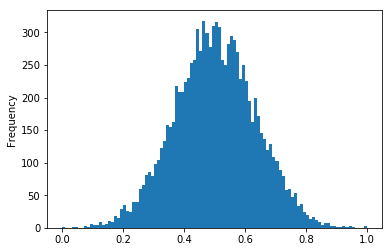

In [3]:
data = skewnorm.rvs(0.01, size=count)
data = min_max_scaling(data)
pd.Series(data).plot.hist(bins=100, range=(0,1))
plt.show()

model1_y_prob = data
model1_name = 'Balanced Model'

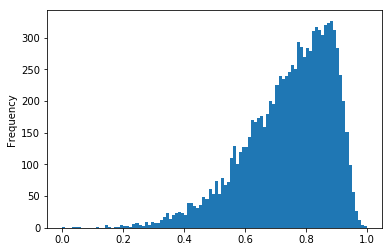

In [4]:
data = skewnorm.rvs(-10, size=count)
data = min_max_scaling(data)
pd.Series(data).plot.hist(bins=100, range=(0,1))
plt.show()

model2_y_prob = data
model2_name = 'Bias Model'

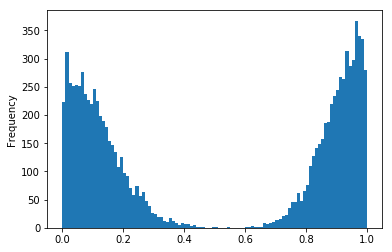

In [5]:
data1 = skewnorm.rvs(100, size=count//2)
data1 = min_max_scaling(data1) * 0.5

data2 = skewnorm.rvs(-100, size=count//2)
data2 = min_max_scaling(data2) * 0.5 + 0.5

data = np.concatenate((data1, data2))
np.random.shuffle(data)

pd.Series(data).plot.hist(bins=100, range=(0,1))
plt.show()

model3_y_prob = data
model3_name = 'Extreme Model'

In [6]:
model_names = [
    model1_name,
    model2_name,
    model3_name
]

model_y_probs = [
    model1_y_prob,
    model2_y_prob,
    model3_y_prob
]

# Create GroudTruths

In [7]:
y_true = np.random.choice(['bad', 'good'], size=count, p = [0.05, 0.95])
pd.Series(y_true).value_counts()

good    9513
bad      487
dtype: int64

In [17]:
json_data = {}
json_data['y_true'] = list(y_true)
json_data['y_preds'] = {}
for model_name, model_y_prob in zip(model_names, model_y_probs):
    json_data['y_preds'][model_name] = list(model_y_prob)

with open('model_evaluation_data.json', 'w') as f:
    f.write(json.dumps(json_data))

# Plot Recall Scores for different Threshold

In [8]:
df_recalls = pd.DataFrame()
thresholds = np.linspace(0, 1, 101)

def get_recalls(threshold, y_prob):
    y_pred = np.array(list(map(lambda x: 'bad' if x <= threshold else 'good',y_prob)))
    recall_bad = recall_score(y_true, y_pred, pos_label='good')
    recall_good = recall_score(y_true, y_pred, pos_label='bad')
    return recall_bad, recall_good

for model_name, model_y_prob in zip(model_names, model_y_probs):
    
    recalls_bad, recalls_good = zip(*list(map(lambda t: get_recalls(t, model_y_prob), 
                                     thresholds)))
    df = pd.DataFrame({
        'threshold': thresholds,
        'recall_bad': recalls_bad,
        'recall_good': recalls_good,
        'model_name': model_name
    })
    
    df_recalls = pd.concat([df_recalls, df])
    
df_recalls.head()

,threshold,recall_bad,recall_good,model_name
0,0.00,0.999895,0.0,Balanced Model
1,0.01,0.999895,0.0,Balanced Model
2,0.02,0.999895,0.0,Balanced Model
3,0.03,0.999895,0.0,Balanced Model
4,0.04,0.999790,0.0,Balanced Model


In [9]:
df_recalls.to_csv('recalls.csv', index=False)

# Plot with Bokeh

In [10]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, Legend

output_notebook()

f = figure()

f.toolbar_location='below'
f.toolbar.logo = None
hover=HoverTool(tooltips=[
    ('Threshold','@threshold{0.00}'),
    ('Recall for Bad','@recall_bad{0.00}'),
    ('Recall of Good','@recall_good{0.00}')
])
f.add_tools(hover)

###############
# Create Source
###############
df = pd.read_csv('recalls.csv').query('model_name == "Extreme Model"')
source = ColumnDataSource(df)

############
# Plot Area
############
f.plot_width=750
f.plot_height=500

#########
# Title
#########
f.title.text = 'Model Evaluation'
f.title.text_font = 'times'
f.title.text_font_size = '25px'
f.title.align = 'center'

############
# Axes
############
f.xaxis.axis_label = 'Threshold'
f.yaxis.axis_label = 'Recall Scores'

########
# Plot
########
line_rb = f.line(x='threshold', 
                 y='recall_bad',
                 source=source,
                 color='red')
line_rg = f.line(x='threshold', 
                 y='recall_good',
                 source=source,
                 color='green')
legend = Legend(items=[
    ("Recall Bad", [line_rb]),
    ("Recall Good", [line_rg])
], location=(0, 320))
f.add_layout(legend, 'right')

show(f)

Loading BokehJS ...